Training set - 2022 Jan to 2024 May
Input window = 28

#### 1. Import the libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2024-11-14 20:51:15.779130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 20:51:17.863796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731617478.575764    3207 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731617478.767375    3207 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 20:51:20.803577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [5]:
# load dataset
data = pd.read_csv('data.csv')

In [6]:
data.tail()

,Received_Timestamp,Latitude,Longitude
813153,2024-08-16 20:26:55,6.301900,94.509340
813154,2024-08-16 20:41:52,6.304237,94.558950
813155,2024-08-16 20:44:07,6.304650,94.566895
813156,2024-08-16 20:44:45,6.304758,94.569090
813157,2024-08-16 21:01:24,6.306820,94.625694


In [7]:
# Remove the 'Longitude' column
data = data.drop(columns=['Latitude'])

In [8]:
data.tail()

,Received_Timestamp,Longitude
813153,2024-08-16 20:26:55,94.509340
813154,2024-08-16 20:41:52,94.558950
813155,2024-08-16 20:44:07,94.566895
813156,2024-08-16 20:44:45,94.569090
813157,2024-08-16 21:01:24,94.625694


In [9]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')       # Convert to numeric, handling errors
#data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [10]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813158 entries, 2022-01-01 00:11:13 to 2024-08-16 21:01:24
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Longitude  813158 non-null  float64
dtypes: float64(1)
memory usage: 12.4 MB


In [12]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_3207/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [13]:
data.head()

,Longitude
Received_Timestamp,
2022-01-01 00:00:00,60.684831
2022-01-01 06:00:00,61.415341
2022-01-01 12:00:00,62.637789
2022-01-01 18:00:00,63.736721
2022-01-02 00:00:00,64.762528


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3836 entries, 2022-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  3836 non-null   float64
dtypes: float64(1)
memory usage: 59.9 KB


In [15]:
scaler = MinMaxScaler()
# Ensure 'Latitude' is in a 2D format before scaling
data['Longitude'] = scaler.fit_transform(data[['Longitude']])

In [16]:
# Training set: Entire year of 2023 and up to August 2024
training_set = data.loc['2022':'2024-05']

# Testing set: Remaining months in 2024, starting from September 2024
testing_set = data.loc['2024-06':]


In [17]:
training_set.head()

,Longitude
Received_Timestamp,
2022-01-01 00:00:00,0.548976
2022-01-01 06:00:00,0.553995
2022-01-01 12:00:00,0.562394
2022-01-01 18:00:00,0.569944
2022-01-02 00:00:00,0.576991


In [18]:
testing_set.head()

,Longitude
Received_Timestamp,
2024-06-01 00:00:00,0.509795
2024-06-01 06:00:00,0.501694
2024-06-01 12:00:00,0.495326
2024-06-01 18:00:00,0.488412
2024-06-02 00:00:00,0.481430


#### 3. Sliding window approach

In [19]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [20]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [21]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 3500
Input shape: (3500, 28, 1), Target shape: (3500, 1)


#### 4. Define LSTM model architecture

In [22]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='tanh', learning_rate=0.001):
    """
    Builds an LSTM model with the given parameters.

    Parameters:
        units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of stacked LSTM layers.
        dropout_rate (float): Dropout rate for regularization.
        recurrent_dropout (float): Dropout rate for the recurrent connections.
        activation (str): Activation function for LSTM layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): Compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add LSTM layers
    for i in range(lstm_layers - 1):
        # Add intermediate LSTM layers with return_sequences=True for stacking
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add the final LSTM layer without return_sequences, as this is a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a Dense layer with 1 unit for output (for regression)
    model.add(Dense(1))
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function, which is suitable for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# Initialize variables to keep track of the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Start with a high initial loss for comparison

# Define hyperparameter grids for tuning
units_list = [50, 100, 150]       # Different numbers of units to try in LSTM layers
layers_list = [1, 2, 3]           # Different numbers of LSTM layers to try
dropout_list = [0.2, 0.3, 0.5]    # Different dropout rates to test for regularization
learning_rates = [0.0001, 0.001, 0.005]  # Different learning rates for the optimizer
batch_sizes = [16, 32, 48]        # Different batch sizes for training

# Perform grid search across all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
                    
                    # Build a model with the current set of hyperparameters
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)
                    
                    # Define early stopping to stop training if validation loss doesn't improve for a number of epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    
                    # Define learning rate scheduler to reduce learning rate if validation loss plateaus
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                    
                    # Train the model on the data with a validation split of 30%
                    # Early stopping and learning rate scheduler will be used as callbacks
                    history = model.fit(X, y, 
                                        epochs=100, 
                                        batch_size=batch_size, 
                                        validation_split=0.3, 
                                        callbacks=[early_stopping, lr_scheduler], 
                                        verbose=1)
                    
                    # Retrieve the minimum validation loss achieved during training
                    val_loss = min(history.history['val_loss'])
                    
                    # Check if the current model has achieved a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and best loss
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history

# At the end of the search, 'best_model' contains the model with the lowest validation loss
# 'best_params' holds the parameters that yielded the best model, and 'best_history' contains the training history


Training model with units=50, layers=1, dropout=0.2, lr=0.0001, batch_size=16
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2401 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0608 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0463 - val_loss: 0.0314 - learning_rate: 1.0000e-04
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0227 - val_loss: 0.0464 - learning_rate: 1.0000e-04
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0190 - val_loss: 0.0452 - learning_rate: 5.0000e-05
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0158 - val_loss: 0.0424 - learning_rate: 5.0000e-05
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0179 - val_loss: 0.0412 - learning_rate: 5.0000e-05
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - 

2024-11-14 20:51:36.323818: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


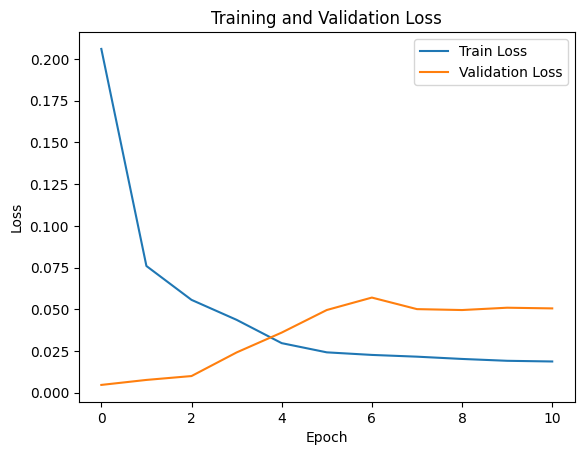

In [23]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=150, Layers=1, Dropout=0.2, Learning Rate=0.0001, Batch Size=48


In [25]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [26]:
best_model

<Sequential name=sequential_164, built=True>

#### 2) Window sampling for testing set

In [27]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 280
Test input shape: (280, 28, 1), Test target shape: (280, 1)


#### 3) Test the Testing Set Using the Imported Model

In [28]:
best_model

<Sequential name=sequential_164, built=True>

In [29]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


#### 4) Calculate Error on the Testing Set

In [30]:
y_test

array([[0.50133581],
       [0.51152297],
       [0.51922561],
       [0.52333456],
       [0.52882524],
       [0.53700599],
       [0.54357378],
       [0.54592623],
       [0.54489517],
       [0.5417422 ],
       [0.53637144],
       [0.52899429],
       [0.52432982],
       [0.51824848],
       [0.51083373],
       [0.50465653],
       [0.49875271],
       [0.49170564],
       [0.48400649],
       [0.47436397],
       [0.46573033],
       [0.45594647],
       [0.44794631],
       [0.43953214],
       [0.43148802],
       [0.42485231],
       [0.42047138],
       [0.41464006],
       [0.40880486],
       [0.40422621],
       [0.40032118],
       [0.39685205],
       [0.3935588 ],
       [0.39033492],
       [0.38697764],
       [0.38286024],
       [0.3784481 ],
       [0.37339746],
       [0.36724973],
       [0.36100544],
       [0.35665732],
       [0.35567446],
       [0.35575703],
       [0.35574423],
       [0.35579592],
       [0.35487639],
       [0.35362572],
       [0.347

In [31]:
y_pred

array([[0.4476298 ],
       [0.44906503],
       [0.45107344],
       [0.4535864 ],
       [0.45643798],
       [0.45957565],
       [0.46303773],
       [0.46677712],
       [0.47060138],
       [0.4742976 ],
       [0.47768942],
       [0.48061338],
       [0.4829262 ],
       [0.4846561 ],
       [0.4857818 ],
       [0.48626712],
       [0.48615915],
       [0.48551297],
       [0.4843404 ],
       [0.48264983],
       [0.48040485],
       [0.47764367],
       [0.47436878],
       [0.47066152],
       [0.4665665 ],
       [0.46212277],
       [0.45742258],
       [0.45259738],
       [0.44767603],
       [0.4426937 ],
       [0.43770328],
       [0.43277365],
       [0.42796293],
       [0.42329356],
       [0.41877082],
       [0.41440174],
       [0.41017234],
       [0.40606454],
       [0.40204287],
       [0.39805126],
       [0.39405742],
       [0.3900898 ],
       [0.38627848],
       [0.38271758],
       [0.37943888],
       [0.37645775],
       [0.37374726],
       [0.371

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.006988203896957888


In [33]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Longitude'])

In [34]:
predictions_df.head()

,Predicted_Longitude
0,0.447630
1,0.449065
2,0.451073
3,0.453586
4,0.456438


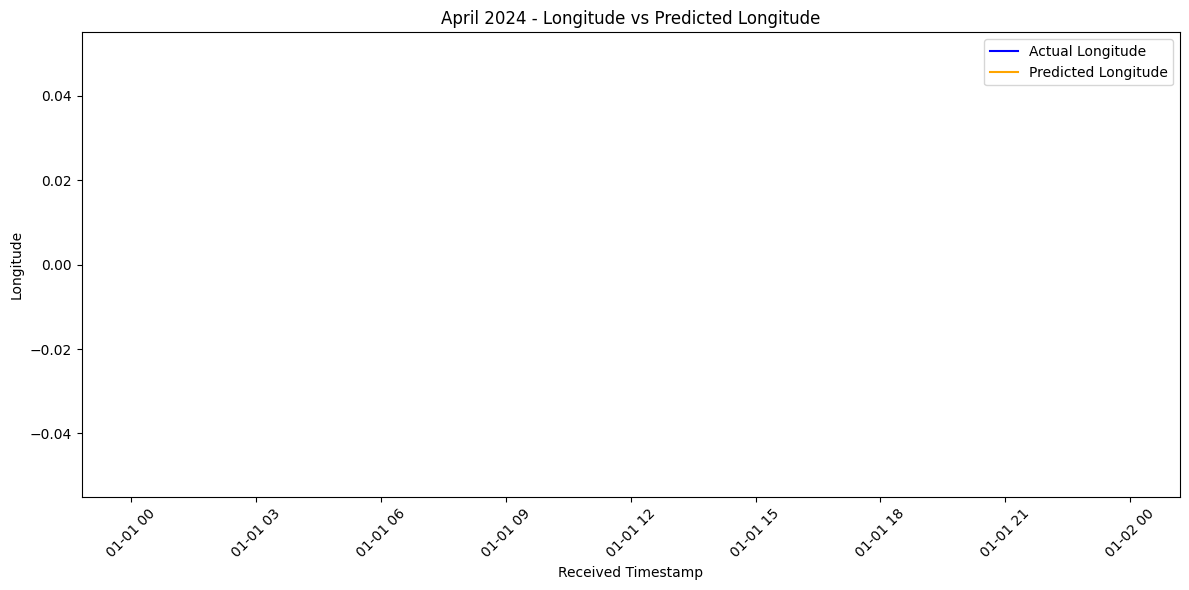

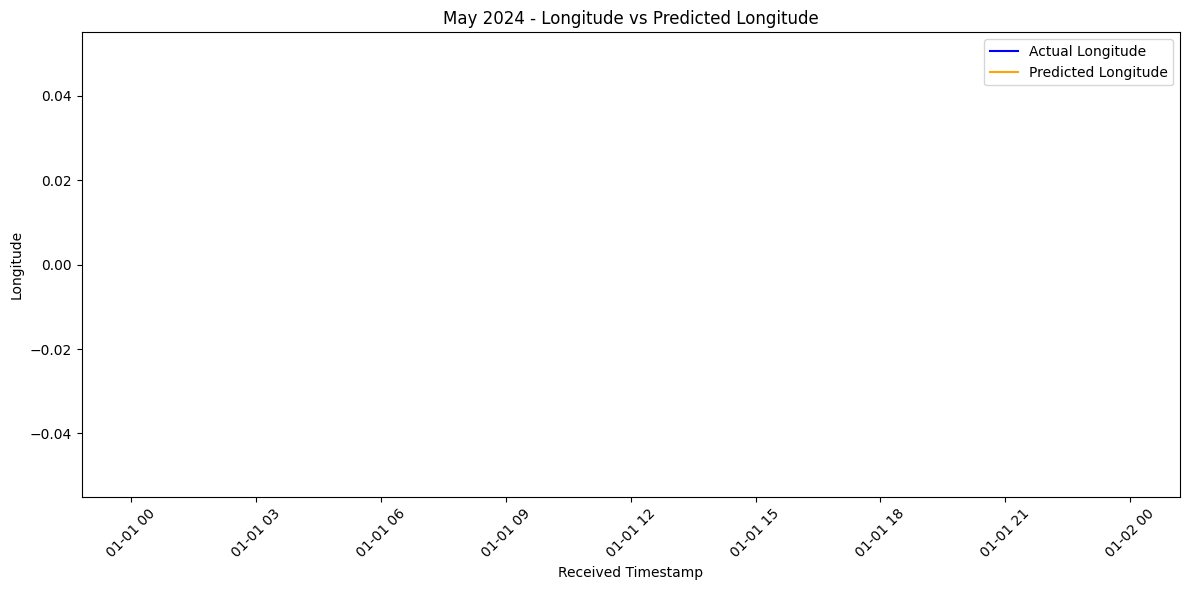

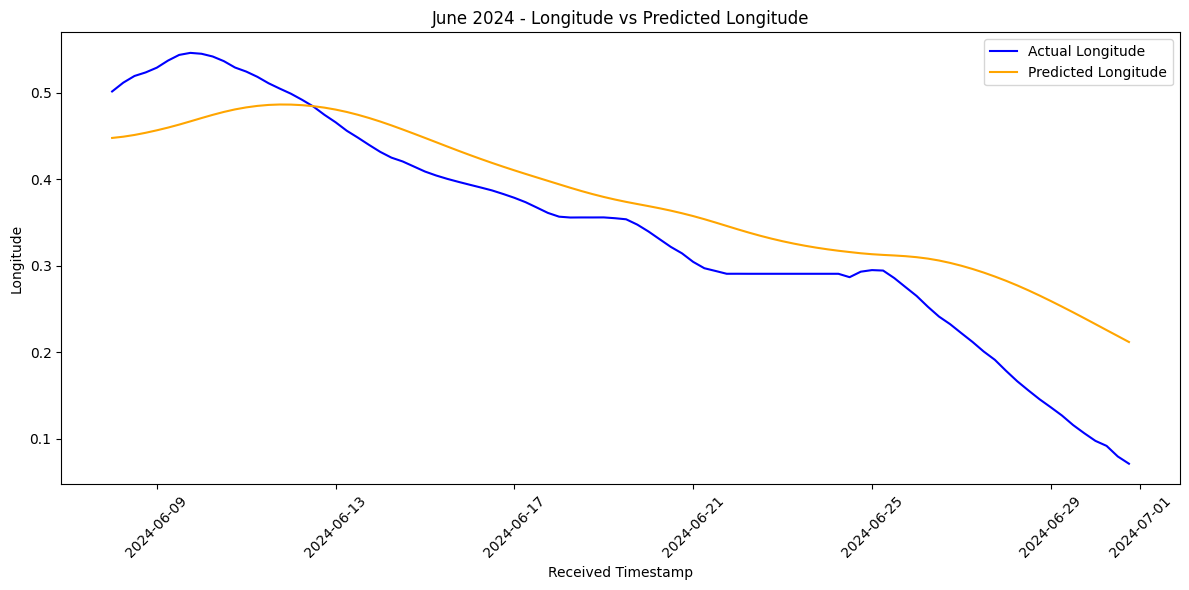

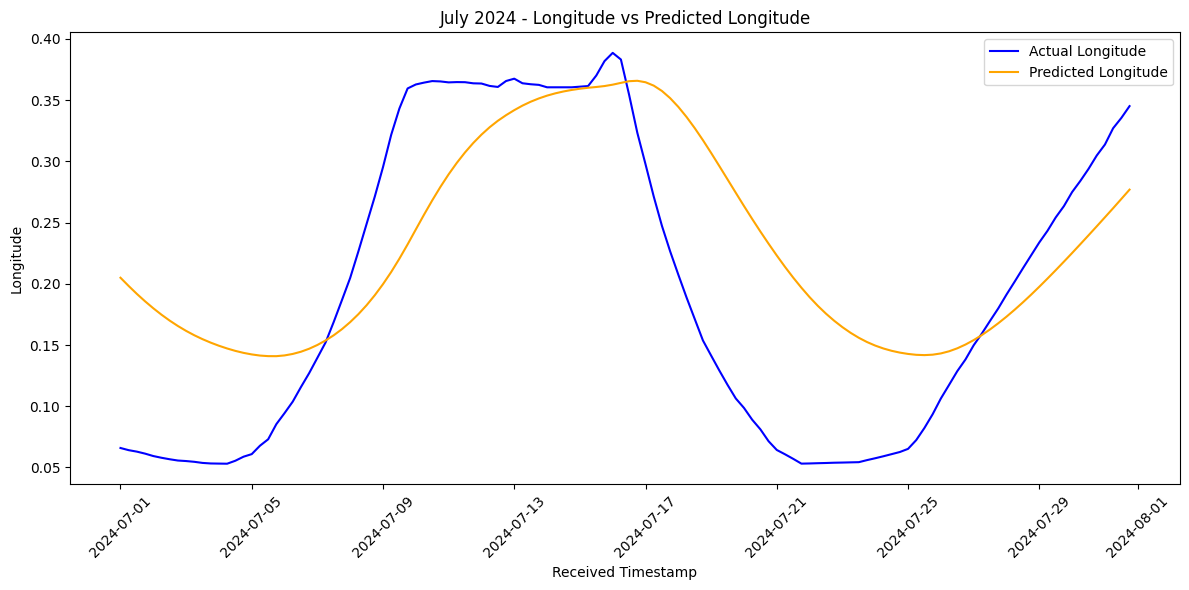

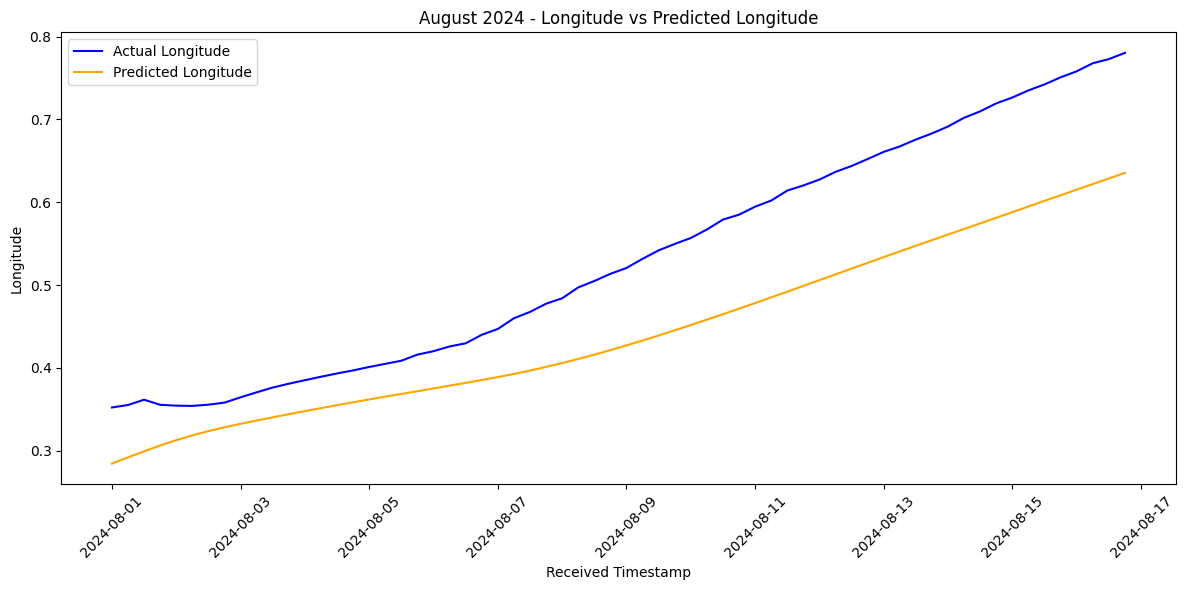

In [35]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_longitude = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Longitude'])

# Add the 'Longitude' column from `testing_set` as the true values for comparison
testing_longitudes = testing_set[['Longitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'April': '2024-04',
    'May': '2024-05',
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_longitudes[testing_longitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_longitude[predicted_longitude.index.to_period('M') == month_str]
    
    # Plot actual vs predicted longitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Longitude'], label='Actual Longitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Longitude'], label='Predicted Longitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Longitude vs Predicted Longitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Longitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [36]:
y_test_real = scaler.inverse_transform(y_test)
#y_test = y_test.reshape(-1, 1)  # Reshape if necessary
#y_pred = y_pred.reshape(-1, 1)  # Reshape if necessary

In [37]:
y_test_real

array([[ 53.75052789],
       [ 55.23332034],
       [ 56.35447688],
       [ 56.95255504],
       [ 57.75175071],
       [ 58.94249819],
       [ 59.89847245],
       [ 60.24088309],
       [ 60.09080768],
       [ 59.63187681],
       [ 58.85013704],
       [ 57.77635611],
       [ 57.09741943],
       [ 56.21225009],
       [ 55.13299727],
       [ 54.23387556],
       [ 53.37454492],
       [ 52.34880912],
       [ 51.22816036],
       [ 49.82464357],
       [ 48.56797607],
       [ 47.14388568],
       [ 45.97942391],
       [ 44.75470054],
       [ 43.58383804],
       [ 42.61797834],
       [ 41.98031184],
       [ 41.13153507],
       [ 40.28219329],
       [ 39.61574802],
       [ 39.04735182],
       [ 38.54240309],
       [ 38.06305435],
       [ 37.59380206],
       [ 37.10513423],
       [ 36.50582598],
       [ 35.86361642],
       [ 35.12847157],
       [ 34.23363883],
       [ 33.32475172],
       [ 32.69186195],
       [ 32.54880178],
       [ 32.5608196 ],
       [ 32

In [38]:
y_pred_real = scaler.inverse_transform(y_pred)
y_pred_real

array([[45.933357 ],
       [46.14226  ],
       [46.434593 ],
       [46.80037  ],
       [47.215427 ],
       [47.672134 ],
       [48.176056 ],
       [48.72034  ],
       [49.27698  ],
       [49.814987 ],
       [50.30868  ],
       [50.73428  ],
       [51.07092  ],
       [51.322716 ],
       [51.486565 ],
       [51.55721  ],
       [51.541492 ],
       [51.447437 ],
       [51.276764 ],
       [51.030693 ],
       [50.703926 ],
       [50.30202  ],
       [49.825348 ],
       [49.285736 ],
       [48.689686 ],
       [48.042877 ],
       [47.358746 ],
       [46.65641  ],
       [45.940086 ],
       [45.21488  ],
       [44.488503 ],
       [43.77097  ],
       [43.070747 ],
       [42.391098 ],
       [41.732788 ],
       [41.096848 ],
       [40.48124  ],
       [39.883327 ],
       [39.297955 ],
       [38.716957 ],
       [38.13563  ],
       [37.55813  ],
       [37.00337  ],
       [36.48506  ],
       [36.007828 ],
       [35.57391  ],
       [35.179386 ],
       [34.81